<a href="https://colab.research.google.com/github/Arbues/Curso-de-Computer-Vision/blob/main/Image_Processing_and_Computer_Vision_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

¿Por qué es tan importante el preprocesamiento de imágenes?
- Ayuda a segementar y en algunos casos reemplazar CNN (como U-net)
- En otros casos nos ayuda a reducir la «Inteligencia» aplicada por una CNN

## 1. Introducción a la representación de imágenes

### 1.1 Fundamentos de la imagen digital

Una imagen digital se representa como una función 2D discreta $f(x, y)$ donde $x$ e $y$ son coordenadas espaciales, y la amplitud de $f$ en cualquier punto $(x, y)$ se denomina intensidad o nivel de gris de la imagen en ese punto. Cuando $x$, $y$ y los valores de amplitud de $f$ son todos finitos y discretos, la llamamos imagen digital.

En términos computacionales, las imágenes se almacenan como matrices multidimensionales:

- Imágenes en escala de grises: Matrices 2D (alto × ancho)/ (height × width)
- Imágenes en color: Matrices 3D (alto × ancho × canales)/ (height × width × channels)

Empecemos por cargar y explorar una imagen de ejemplo:

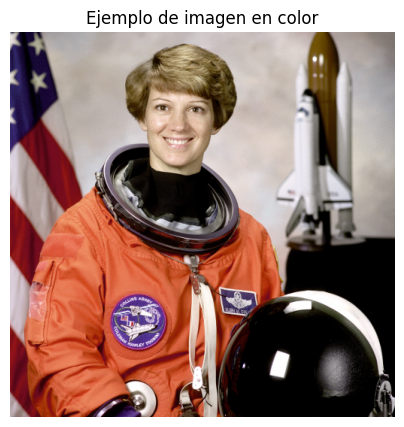

Dimensiones de la Imagen (height, width, channels): (512, 512, 3)
Tipo de datos: uint8
Min Valor: 0, Max valor: 255
Pixel en (100, 100): [187 176 169] (RGB)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, data, filters
import cv2

# Cargar la imagen
sample_image = data.astronaut()  # Esto por defecto es una imagen a color

# Mostramos la imagen
plt.figure(figsize=(5, 5))
plt.imshow(sample_image)
plt.title('Ejemplo de imagen en color')
plt.axis('off')
plt.show()

# Imprimimos sus tamaños y otras
print(f"Dimensiones de la Imagen (height, width, channels): {sample_image.shape}")
print(f"Tipo de datos: {sample_image.dtype}")
print(f"Min Valor: {sample_image.min()}, Max valor: {sample_image.max()}")

# Accedemso a un solo pixel
pixel = sample_image[100, 100]
print(f"Pixel en (100, 100): {pixel} (RGB)")

### 1.2 Canales de color

Las imágenes en color suelen representarse mediante tres canales: Rojo, Verde y Azul (RGB). Cada canal es una matriz 2D independiente que representa la intensidad de ese componente de color. Combinando estos canales, podemos representar millones de colores.
![](https://i.imgur.com/gQxzDHg.png)



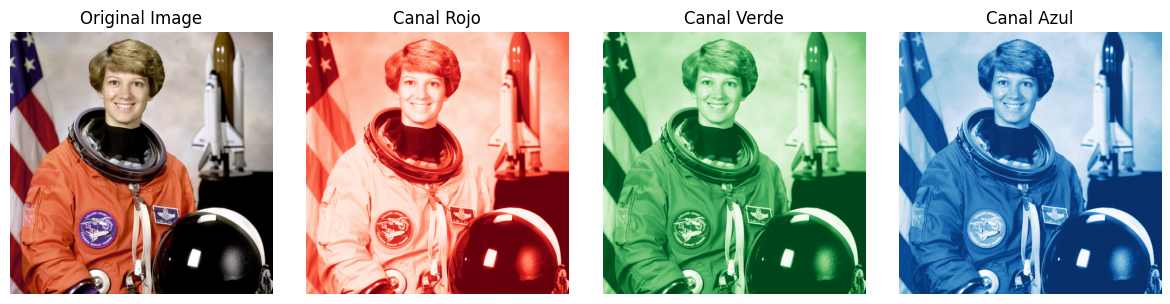

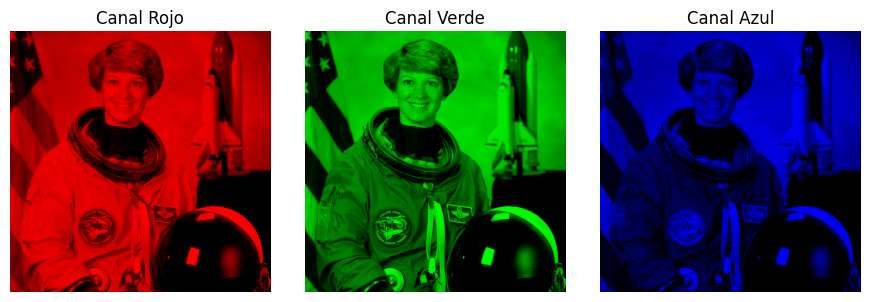

In [2]:
# Extraer y mostrar canales de color individuales
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

# Imagen original
axes[0].imshow(sample_image)
axes[0].set_title('Original Image')
axes[0].axis('off')

#╔══════════════════════════════════════════╗
#║              1 metodo			           		║
#╚══════════════════════════════════════════╝

# Canal Rojo
axes[1].imshow(sample_image[:, :, 0], cmap='Reds_r')
axes[1].set_title('Canal Rojo')
axes[1].axis('off')

# Canal Verde
axes[2].imshow(sample_image[:, :, 1], cmap='Greens_r')
axes[2].set_title('Canal Verde')
axes[2].axis('off')

# Canal Azul
axes[3].imshow(sample_image[:, :, 2], cmap='Blues_r')
axes[3].set_title('Canal Azul')
axes[3].axis('off')

plt.tight_layout()
plt.show()


#╔══════════════════════════════════════════╗
#║              2 metodo			           		║
#╚══════════════════════════════════════════╝

red_channel = sample_image.copy()
red_channel[:, :, 1] = 0  # Zero out G
red_channel[:, :, 2] = 0  # Zero out B

green_channel = sample_image.copy()
green_channel[:, :, 0] = 0  # Zero out R
green_channel[:, :, 2] = 0  # Zero out B

blue_channel = sample_image.copy()
blue_channel[:, :, 0] = 0  # Zero out R
blue_channel[:, :, 1] = 0  # Zero out G

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
axes[0].imshow(red_channel)
axes[0].set_title('Canal Rojo')
axes[0].axis('off')

axes[1].imshow(green_channel)
axes[1].set_title('Canal Verde')
axes[1].axis('off')

axes[2].imshow(blue_channel)
axes[2].set_title('Canal Azul')
axes[2].axis('off')

plt.tight_layout()
plt.show()

#### **Porque el 1 metodo se ve mas "fuerte" que el segundo?**
RPT:

### 1.3 Espacios de color

Un espacio de color es una organización específica de colores. Los diferentes espacios de color tienen diferentes propiedades y se utilizan para diferentes propósitos.

#### A ejecutar previamente mas no es nesesario analizar el codigo

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from matplotlib.colors import hsv_to_rgb, rgb_to_hsv
import ipywidgets as widgets
from IPython.display import display

def create_rgb_visualizer():
    """Widget interactivo para visualizar el espacio de color RGB"""

    # Crear los sliders para R, G, B
    r_slider = widgets.IntSlider(min=0, max=255, step=1, value=128,
                                description='Red:', style={'description_width': '50px'})
    g_slider = widgets.IntSlider(min=0, max=255, step=1, value=128,
                                description='Green:', style={'description_width': '50px'})
    b_slider = widgets.IntSlider(min=0, max=255, step=1, value=128,
                                description='Blue:', style={'description_width': '50px'})

    color_box = widgets.HTML(
        value=f'<div style="background-color: rgb({r_slider.value},{g_slider.value},{b_slider.value}); '
              f'width: 200px; height: 200px; border: 1px solid black;"></div>',
        layout=widgets.Layout(height='220px')
    )

    hex_value = widgets.Text(
        value=f'#{r_slider.value:02x}{g_slider.value:02x}{b_slider.value:02x}',
        description='Hex:',
        disabled=True,
        style={'description_width': '50px'}
    )

    # Función para actualizar la visualización
    def update_color(change):
        r, g, b = r_slider.value, g_slider.value, b_slider.value
        color_box.value = f'<div style="background-color: rgb({r},{g},{b}); ' \
                          f'width: 200px; height: 200px; border: 1px solid black;"></div>'
        hex_value.value = f'#{r:02x}{g:02x}{b:02x}'

    # Vincular la función a los sliders
    r_slider.observe(update_color, names='value')
    g_slider.observe(update_color, names='value')
    b_slider.observe(update_color, names='value')

    # Organizar el layout
    sliders = widgets.VBox([r_slider, g_slider, b_slider, hex_value])
    output = widgets.HBox([sliders, color_box])

    return output

def create_grayscale_visualizer():
    """Widget interactivo para visualizar la conversión a escala de grises desde RGB"""

    # Crear los sliders para R, G, B con valores de 0-255
    r_slider = widgets.IntSlider(min=0, max=255, step=1, value=128,
                                description='Red:', style={'description_width': '50px'})
    g_slider = widgets.IntSlider(min=0, max=255, step=1, value=128,
                                description='Green:', style={'description_width': '50px'})
    b_slider = widgets.IntSlider(min=0, max=255, step=1, value=128,
                                description='Blue:', style={'description_width': '50px'})

    rgb_box = widgets.HTML(
        value=f'<div style="background-color: rgb({r_slider.value},{g_slider.value},{b_slider.value}); '
              f'width: 200px; height: 200px; border: 1px solid black;"></div>',
        layout=widgets.Layout(height='220px')
    )

    # Calcular el valor de gris usando la fórmula ponderada
    gray_value = int(0.299 * r_slider.value + 0.587 * g_slider.value + 0.114 * b_slider.value)

    gray_box = widgets.HTML(
        value=f'<div style="background-color: rgb({gray_value},{gray_value},{gray_value}); '
              f'width: 200px; height: 200px; border: 1px solid black;"></div>',
        layout=widgets.Layout(height='220px')
    )

    formula_display = widgets.HTML(
        value=f'Gray = 0.299*R + 0.587*G + 0.114*B = {gray_value}',
        layout=widgets.Layout(height='30px')
    )

    # Función para actualizar la visualización
    def update_color(change):
        r, g, b = r_slider.value, g_slider.value, b_slider.value
        rgb_box.value = f'<div style="background-color: rgb({r},{g},{b}); ' \
                        f'width: 200px; height: 200px; border: 1px solid black;"></div>'

        gray_value = int(0.299 * r + 0.587 * g + 0.114 * b)
        gray_box.value = f'<div style="background-color: rgb({gray_value},{gray_value},{gray_value}); ' \
                        f'width: 200px; height: 200px; border: 1px solid black;"></div>'

        formula_display.value = f'Gray = 0.299*{r} + 0.587*{g} + 0.114*{b} = {gray_value}'

    # Vincular la función a los sliders
    r_slider.observe(update_color, names='value')
    g_slider.observe(update_color, names='value')
    b_slider.observe(update_color, names='value')

    # Organizar el layout
    sliders = widgets.VBox([r_slider, g_slider, b_slider, formula_display])
    colors = widgets.HBox([rgb_box, gray_box])
    output = widgets.VBox([sliders, colors])

    return output

def create_hsv_visualizer():
    """Widget interactivo para visualizar el espacio de color HSV"""

    # Crear los sliders para H (0-360), S (0-100), V (0-100) para una experiencia más intuitiva
    h_slider = widgets.IntSlider(min=0, max=360, step=1, value=180,
                                description='Hue:', style={'description_width': '70px'})
    s_slider = widgets.IntSlider(min=0, max=100, step=1, value=100,
                                description='Saturation:', style={'description_width': '70px'})
    v_slider = widgets.IntSlider(min=0, max=100, step=1, value=100,
                                description='Value:', style={'description_width': '70px'})

    color_box = widgets.HTML(
        value='<div style="background-color: #00FFFF; width: 200px; height: 200px; border: 1px solid black;"></div>',
        layout=widgets.Layout(height='220px')
    )

    hsv_display = widgets.Text(
        value=f'H: {h_slider.value}°, S: {s_slider.value}%, V: {v_slider.value}%',
        description='HSV:',
        disabled=True,
        style={'description_width': '50px'}
    )

    # Función para actualizar la visualización
    def update_color(change):
        h, s, v = h_slider.value/360.0, s_slider.value/100.0, v_slider.value/100.0
        # Convertir HSV a RGB
        rgb = hsv_to_rgb(np.array([[[h, s, v]]]))[0][0]
        # Escalar a 0-255
        r, g, b = [int(c * 255) for c in rgb]
        color_box.value = f'<div style="background-color: rgb({r},{g},{b}); ' \
                          f'width: 200px; height: 200px; border: 1px solid black;"></div>'
        hsv_display.value = f'H: {h_slider.value}°, S: {s_slider.value}%, V: {v_slider.value}%'

    # Vincular la función a los sliders
    h_slider.observe(update_color, names='value')
    s_slider.observe(update_color, names='value')
    v_slider.observe(update_color, names='value')

    # Organizar el layout
    sliders = widgets.VBox([h_slider, s_slider, v_slider, hsv_display])
    output = widgets.HBox([sliders, color_box])

    return output


#### RGB (Rojo, Verde, Azul)

Este es el espacio de color más común para las pantallas electrónicas. Los colores se forman añadiendo diferentes cantidades de luz roja, verde y azul.

![](https://i.imgur.com/M1jW5PG.png)



In [4]:
# Mostrar los visualizadores
print("Visualizador de espacio de color RGB:")
display(create_rgb_visualizer())

Visualizador de espacio de color RGB:


#### Escala de grises

Una representación de un solo canal en la que cada píxel representa solo la información de intensidad. La conversión de RGB a escala de grises suele utilizar una suma ponderada:

$$\text{Gris} = 0.299 \times \text{Rojo} + 0.587 \times \text{Verde} + 0.114 \times \text{Azul}$$



In [5]:
print("\nVisualizador de conversión en escala de grises:")
display(create_grayscale_visualizer())


Visualizador de conversión en escala de grises:


#### HSV (Hue, Saturation, Value)
También conocido como HSB (HSL es una ligera modificación de los anteriores y no es de uso común)

- **Hue**: El tipo de color (por ejemplo, rojo, azul, amarillo)
- **Saturation**: La intensidad o pureza del color
- **Value**: El brillo del color

HSV es particularmente útil para la segmentación basada en color porque separa la información de color (Hue) de la iluminación (value).

![](https://i.imgur.com/4gaHJ6U.png)




In [6]:
print("\nVisualizador de espacio de color HSV:")
display(create_hsv_visualizer())
## Ojo que por dentro ya tienes que pasarlo normalizado, osea todos [0-1]


Visualizador de espacio de color HSV:


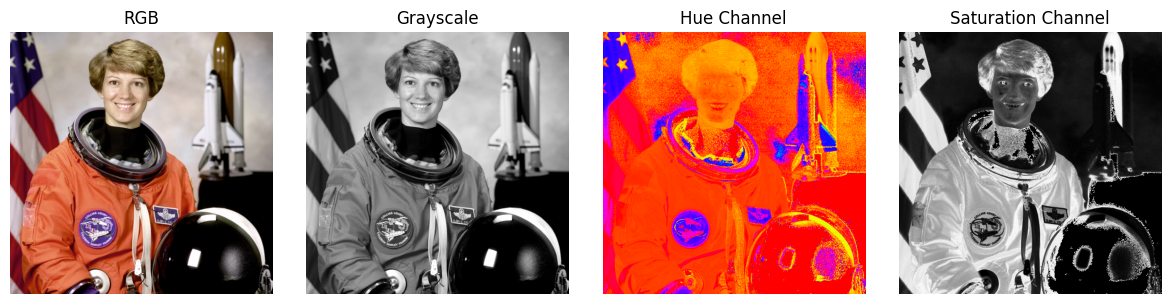

In [7]:
# Convert between color spaces
rgb_img = data.astronaut()


####################### CODIGO PRINCIPAL #######################
gray_img = color.rgb2gray(rgb_img) ## RGB ---> grayscale
hsv_img = color.rgb2hsv(rgb_img)   ## RGB ---> HSV
####################### CODIGO PRINCIPAL #######################


# Display different color spaces
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

# Original RGB
axes[0].imshow(rgb_img)
axes[0].set_title('RGB')
axes[0].axis('off')

# Grayscale
axes[1].imshow(gray_img, cmap='gray')
axes[1].set_title('Grayscale')
axes[1].axis('off')

# HSV (showing individual channels)
axes[2].imshow(hsv_img[:, :, 0], cmap='hsv')
axes[2].set_title('Hue Channel')
axes[2].axis('off')

axes[3].imshow(hsv_img[:, :, 1], cmap='gray')
axes[3].set_title('Saturation Channel')
axes[3].axis('off')

plt.tight_layout()
plt.show()

### 1.5 Aplicación práctica: Segmentación basada en colores

HSV es particularmente útil para la segmentación basada en color porque separa la información de color (Hue) de las condiciones de iluminación (value).
Quiero decir, en otras palabras, en RGB te mueves en el espacio de color bruscamente para encontrar otro color; por otro lado en el espacio HSV te mueves , aparte de buscar otros colores similares, a encontrar diferentes tonos de luz y oscuridad.
Veamos cómo podemos usarlo para extraer objetos de un color específico:

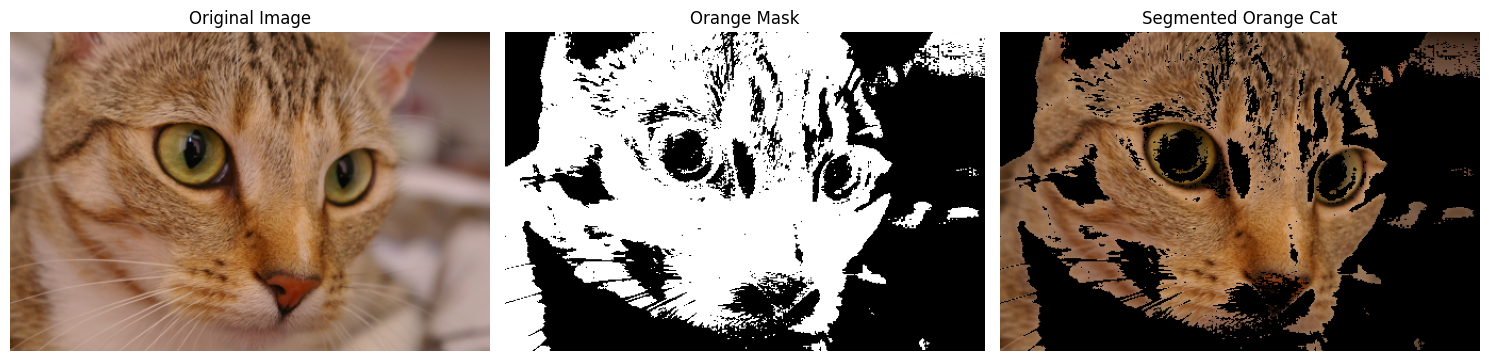

In [8]:
# Download an example image
def download_image():
    import urllib.request
    try:
        urllib.request.urlretrieve(
            "https://raw.githubusercontent.com/scikit-image/scikit-image/master/skimage/data/chelsea.png",
            "chelsea.png")
        return io.imread("chelsea.png")
    except:
        return data.chelsea()  # Fallback to built-in image if download fails

img = download_image()

# Convert to HSV
img_hsv = color.rgb2hsv(img)



####################### CODIGO PRINCIPAL #######################

# Define orange color range in HSV
# The cat in the image is orange, so we'll try to isolate it
lower_orange = np.array([0.05, 0.4, 0.4])  # Lower bound for orange
upper_orange = np.array([0.11, 1.0, 1.0])  # Upper bound for orange

####################### CODIGO PRINCIPAL #######################



# Create binary mask for orange pixels
mask = np.logical_and(
    np.logical_and(img_hsv[:,:,0] >= lower_orange[0], img_hsv[:,:,0] <= upper_orange[0]),
    np.logical_and(img_hsv[:,:,1] >= lower_orange[1], img_hsv[:,:,1] <= upper_orange[1])
)

# Apply mask to original image
result = img.copy()
result[~mask] = [0, 0, 0]  # Set non-orange pixels to black

# Display the results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Orange Mask')
axes[1].axis('off')

axes[2].imshow(result)
axes[2].set_title('Segmented Orange Cat')
axes[2].axis('off')

plt.tight_layout()
plt.show()

#### Sorpresita (1 MASCARA)


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from ipywidgets import interact, FloatSlider, VBox, HBox, Layout
import ipywidgets as widgets
from IPython.display import display, clear_output

# Cargar la imagen desde la ruta específica
img = io.imread("/content/sample_data/PROBES/imagen4.jpg")

# Convertir a HSV
img_hsv = color.rgb2hsv(img)

# Valores iniciales centrados alrededor del verde (72°, 100%, 100%)
# Convertir 72° a espacio normalizado: 72/360 = 0.2
H_TARGET = 0.2
H_TOLERANCE = 0.02
S_MIN_DEFAULT = 0.4
S_MAX_DEFAULT = 1.0
V_MIN_DEFAULT = 0.4
V_MAX_DEFAULT = 1.0

# Función para actualizar la segmentación basada en los valores HSV
def update_segmentation(h_min, h_max, s_min, s_max, v_min, v_max):
    # Create binary mask for the specified HSV range
    mask = np.logical_and(
        np.logical_and(img_hsv[:,:,0] >= h_min, img_hsv[:,:,0] <= h_max),
        np.logical_and(
            np.logical_and(img_hsv[:,:,1] >= s_min, img_hsv[:,:,1] <= s_max),
            np.logical_and(img_hsv[:,:,2] >= v_min, img_hsv[:,:,2] <= v_max)
        )
    )

    # Apply mask to original image
    result = img.copy()
    result[~mask] = [0, 0, 0]  # Set non-matching pixels to black

    # Display the results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('HSV Mask')
    axes[1].axis('off')

    axes[2].imshow(result)
    axes[2].set_title('Segmented Objects')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    # Print the current HSV range values
    print(f"Current HSV Range:")
    print(f"H: {h_min:.2f} - {h_max:.2f} ({h_min*360:.1f}° - {h_max*360:.1f}°)")
    print(f"S: {s_min:.2f} - {s_max:.2f}")
    print(f"V: {v_min:.2f} - {v_max:.2f}")

# Crear los controles deslizantes para HSV
h_min_slider = FloatSlider(value=H_TARGET-H_TOLERANCE, min=0, max=1.0, step=0.01, description='H min:')
h_max_slider = FloatSlider(value=H_TARGET+H_TOLERANCE, min=0, max=1.0, step=0.01, description='H max:')
s_min_slider = FloatSlider(value=S_MIN_DEFAULT, min=0, max=1.0, step=0.01, description='S min:')
s_max_slider = FloatSlider(value=S_MAX_DEFAULT, min=0, max=1.0, step=0.01, description='S max:')
v_min_slider = FloatSlider(value=V_MIN_DEFAULT, min=0, max=1.0, step=0.01, description='V min:')
v_max_slider = FloatSlider(value=V_MAX_DEFAULT, min=0, max=1.0, step=0.01, description='V max:')

# Crear un widget interactivo
interact(
    update_segmentation,
    h_min=h_min_slider,
    h_max=h_max_slider,
    s_min=s_min_slider,
    s_max=s_max_slider,
    v_min=v_min_slider,
    v_max=v_max_slider
)

interactive(children=(FloatSlider(value=0.18000000000000002, description='H min:', max=1.0, step=0.01), FloatS…

<function __main__.update_segmentation(h_min, h_max, s_min, s_max, v_min, v_max)>

Observacmos que con una variacion de

H = 0.17 - 0.3   
S = 0.11 - 1    
V = 0.35 - 1

Tenemos buenso resultados


Pero que Pasa cuando no tenemos o sabemso el color que se tiene que identificar?
AHORA VAMOS A VER EL PROYECTITO 1, VE A LA CARPETA Problema1 y lee su readme

## 2. Operaciones Básicas y Transformaciones de Imágenes



### 2.1 Operaciones de Punto (Point Operations)

Las operaciones de punto modifican los valores de los píxeles de forma independiente, sin considerar sus vecinos. La forma general es:

$$g(x,y) = T[f(x,y)]$$

donde $f(x,y)$ es la imagen de entrada, $g(x,y)$ es la imagen de salida, y $T$ es la función de transformación.

#### Operaciones de Punto Comunes:

1. **Negativo**: Invierte los niveles de intensidad
   $$g(x,y) = L - 1 - f(x,y)$$
   donde $L$ es el nivel máximo de intensidad (255 para imágenes de 8 bits)
    
2. **Umbralización (Thresholding)**: Convierte a binario basado en un valor umbral $T$
   $$g(x,y) = \begin{cases} 1 & \text{si } f(x,y) > T \\ 0 & \text{en otro caso} \end{cases}$$
    
3. **Ajuste de Brillo**: Añade una constante para aumentar o disminuir el brillo
   $$g(x,y) = f(x,y) + b$$
    
4. **Ajuste de Contraste**: Multiplica por un factor para aumentar o disminuir el contraste
   $$g(x,y) = c \cdot f(x,y)$$
Cuando es mayor a 1 aumenta el contraste, cuando es entre 0 y 1 disminuye

A continuación, implementaremos estas operaciones con controles interactivos para ver su efecto en tiempo real.

In [45]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, exposure

# Cargar una imagen en escala de grises directamente (sin convertir)
img = data.camera()
#img = io.imread("/content/sample_data/P1050459.JPG")


# Determinar el rango de la imagen automáticamente
img_min = img.min()
img_max = img.max()

print(f"Información de la imagen:")
print(f"Tipo de datos: {img.dtype}")
print(f"Valor mínimo: {img_min}")
print(f"Valor máximo: {img_max}")
print(f"Forma: {img.shape}")

# Crear el visualizador interactivo
def create_point_operations_visualizer():
    # Crear widgets para los controles
    operation_dropdown = widgets.Dropdown(
        options=[
            ('Negativo', 'negative'),
            ('Umbralización', 'threshold'),
            ('Ajuste de Brillo', 'brightness'),
            ('Ajuste de Contraste', 'contrast')
        ],
        value='negative',
        description='Operación:',
        style={'description_width': 'initial'}
    )

    threshold_slider = widgets.FloatSlider(
        value=128,
        min=0,
        max=255,
        step=1,
        description='Umbral:',
        disabled=True,
        style={'description_width': 'initial'}
    )

    brightness_slider = widgets.FloatSlider(
        value=0,
        min=-128,  # Rango más balanceado para evitar problemas
        max=128,
        step=1,
        description='Brillo:',
        disabled=True,
        style={'description_width': 'initial'}
    )

    contrast_slider = widgets.FloatSlider(
        value=1.0,
        min=0.01,
        max=3.0,
        step=0.1,
        description='Contraste:',
        disabled=True,
        style={'description_width': 'initial'}
    )

    # Widget para mostrar/ocultar histogramas
    show_histogram = widgets.Checkbox(
        value=False,
        description='Mostrar histogramas',
        style={'description_width': 'initial'}
    )

    output = widgets.Output()

    # Función para crear y mostrar histogramas
    def plot_histogram(ax, image, title):
        hist, bin_centers = exposure.histogram(image)
        ax.plot(bin_centers, hist, lw=2)
        ax.set_title(title)
        ax.set_xlabel('Valor de Píxel')
        ax.set_ylabel('Frecuencia')
        ax.grid(True)

    # Función para actualizar la visualización según los controles
    def update_view(*args):
        with output:
            output.clear_output(wait=True)

            # Habilitar/deshabilitar controles según la operación seleccionada
            threshold_slider.disabled = operation_dropdown.value != 'threshold'
            brightness_slider.disabled = operation_dropdown.value != 'brightness'
            contrast_slider.disabled = operation_dropdown.value != 'contrast'


            ########################################## CODIGO PRINCIPAL ##########################################

            # Aplicar la operación seleccionada
            # IMPORTANTE: Se asume rango 0-255 para operaciones (uint8)
            if operation_dropdown.value == 'negative':
                result = 255 - img
                title = 'Negativo'
            elif operation_dropdown.value == 'threshold':
                result = (img > threshold_slider.value) * 255
                title = f'Umbralización (T={threshold_slider.value:.0f})'
            elif operation_dropdown.value == 'brightness':
                result = np.clip(img.astype(np.float32) + brightness_slider.value, 0, 255).astype(np.uint8)
                title = f'Ajuste de Brillo ({brightness_slider.value:+.0f})'
            elif operation_dropdown.value == 'contrast':
                # Aplicar contraste centrado en 128
                result = np.clip(128 + contrast_slider.value * (img.astype(np.float32) - 128), 0, 255).astype(np.uint8)
                title = f'Ajuste de Contraste (×{contrast_slider.value:.1f})'
            ########################################## CODIGO PRINCIPAL ##########################################


            # Crear figura basada en si se muestran los histogramas o no
            if show_histogram.value:
                # Crear figura con 2 filas: imágenes arriba, histogramas abajo
                fig, axes = plt.subplots(2, 2, figsize=(14, 10))

                # Mostrar imágenes en la fila superior
                axes[0, 0].imshow(img, cmap='gray')
                axes[0, 0].set_title('Imagen Original')
                axes[0, 0].axis('off')

                axes[0, 1].imshow(result, cmap='gray')
                axes[0, 1].set_title(title)
                axes[0, 1].axis('off')

                # Mostrar histogramas en la fila inferior
                plot_histogram(axes[1, 0], img, 'Histograma Original')
                plot_histogram(axes[1, 1], result, f'Histograma después de {title}')

                # Ajustar para mejor visualización
                plt.tight_layout()
                plt.subplots_adjust(hspace=0.3)
            else:
                # Solo mostrar imágenes
                fig, axes = plt.subplots(1, 2, figsize=(12, 6))
                axes[0].imshow(img, cmap='gray', vmin=0, vmax=255) ### SI NO HACEMOS ESTO DE MIN Y MAX, plt hace automaticamente el estiramiento de contraste
                axes[0].set_title('Imagen Original')
                axes[0].axis('off')

                axes[1].imshow(result, cmap='gray', vmin=0, vmax=255)
                axes[1].set_title(title)
                axes[1].axis('off')

                plt.tight_layout()

            plt.show()

            # Si estamos ajustando el contraste y este es menor a 1,
            # mostrar información adicional sobre el comportamiento
            if operation_dropdown.value == 'contrast' and contrast_slider.value < 1.0:
                # Calcular cuántos píxeles están en el extremo inferior (valor 0)
                zeros_original = np.sum(img == 0)
                zeros_result = np.sum(result == 0)

                print(f"\nObservación sobre contraste bajo (×{contrast_slider.value:.2f}):")
                print(f"- Píxeles con valor 0 en imagen original: {zeros_original}")
                print(f"- Píxeles con valor 0 en imagen resultante: {zeros_result}")
                print("- Nota: Los píxeles que ya eran totalmente negros (valor 0) permanecen en 0 ")
                print("  incluso con contraste bajo, ya que 128 + contraste*(0-128) = 128-128*contraste,")
                print("  que sigue siendo 0 tras el recorte (clip) si es negativo.")

    # Vincular la función de actualización a los widgets
    operation_dropdown.observe(update_view, names='value')
    threshold_slider.observe(update_view, names='value')
    brightness_slider.observe(update_view, names='value')
    contrast_slider.observe(update_view, names='value')
    show_histogram.observe(update_view, names='value')

    # Crear la interfaz
    controls = widgets.VBox([
        operation_dropdown,
        threshold_slider,
        brightness_slider,
        contrast_slider,
        show_histogram
    ])

    # Mostrar la visualización inicial
    update_view()

    return widgets.VBox([controls, output])

# Mostrar el visualizador
display(create_point_operations_visualizer())

Información de la imagen:
Tipo de datos: uint8
Valor mínimo: 0
Valor máximo: 255
Forma: (512, 512)


### 2.2 Histogram and Histogram Equalization


El histograma de una imagen representa la distribución de frecuencia de las intensidades de píxeles. En una imagen en escala de grises, el histograma es un gráfico que muestra el número de píxeles en cada valor de intensidad.

La ecualización del histograma es una técnica que redistribuye los valores de intensidad de los píxeles para ocupar todo el rango disponible, transformando el histograma original en uno con distribución más uniforme (literal), mejorando así el contraste global de la imagen sin alterar el orden relativo de los valores.

$$h(v) = \text{round}\left((L-1) \cdot \sum_{i=0}^{v} \frac{p(i)}{N \cdot M}\right)$$

where:

- $h(v)$ es la nueva intensidad para el valor $v$
- $L$ es el número de valores de intensidad posibles (e.g., 256 para 8-bit)
- $p(i)$ es el número de píxeles con intensidad $i$
- $N \times M$ es el número total de píxeles de la imagen

In [43]:
from skimage import exposure, data
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Load a low-contrast image
img = data.moon()

# Function to create visualization with interactive CLAHE parameters
def visualize_histograms(clip_limit=0.03, kernel_size=64):
    # Calculate histograms
    hist_orig, centers_orig = exposure.histogram(img)

    ##################### CODIGO PRINCIPAL #####################

    # Ecualización de histograma tradicional
    # Mejora el contraste global distribuyendo uniformemente las intensidades
    img_eq = exposure.equalize_hist(img)

    # CLAHE: Ecualización adaptativa de histograma con límite de contraste
    # Mejora el contraste local mientras evita amplificar el ruido
    # clip_limit: controla el límite de amplificación de contraste, medida de que tnato amplifica las sombras
    # kernel_size: tamaño de la región local (8x8 por defecto), # se usa cuando quieres notar la diferenia de sombras mas fino, valor alto es sobras mas regionales
    img_adapteq = exposure.equalize_adapthist(img, clip_limit=clip_limit, kernel_size=kernel_size)

    ##################### CODIGO PRINCIPAL #####################

    # Calculate histograms for processed images
    hist_eq, centers_eq = exposure.histogram(img_eq)
    hist_adapteq, centers_adapteq = exposure.histogram(img_adapteq)

    # Create figure with 2 rows
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Row 1: Images
    axes[0, 0].imshow(img, cmap='gray')
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(img_eq, cmap='gray')
    axes[0, 1].set_title('Standard Histogram Equalization')
    axes[0, 1].axis('off')

    axes[0, 2].imshow(img_adapteq, cmap='gray')
    axes[0, 2].set_title(f'Adaptive Equalization (CLAHE)\nclip_limit={clip_limit}, kernel_size={kernel_size}')
    axes[0, 2].axis('off')

    # Row 2: Histograms
    axes[1, 0].plot(centers_orig, hist_orig, lw=2)
    axes[1, 0].set_title('Original Histogram')
    axes[1, 0].set_xlabel('Pixel Value')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].grid(True)

    axes[1, 1].plot(centers_eq, hist_eq, lw=2)
    axes[1, 1].set_title('Standard Equalized Histogram')
    axes[1, 1].set_xlabel('Pixel Value')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].grid(True)

    axes[1, 2].plot(centers_adapteq, hist_adapteq, lw=2)
    axes[1, 2].set_title('Adaptive Equalized Histogram')
    axes[1, 2].set_xlabel('Pixel Value')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].grid(True)

    plt.tight_layout()
    plt.show()

# Create interactive widgets for CLAHE parameters
clip_slider = widgets.FloatSlider(
    value=0.03,
    min=0.001,
    max=0.1,
    step=0.005,
    description='Clip Limit:',
    style={'description_width': 'initial'}
)

kernel_slider = widgets.IntSlider(
    value=64,
    min=8,
    max=128,
    step=8,
    description='Kernel Size:',
    style={'description_width': 'initial'}
)

# Connect the interactive widgets to the visualization function
interactive_plot = widgets.interactive(
    visualize_histograms,
    clip_limit=clip_slider,
    kernel_size=kernel_slider
)

# Display the interactive visualization
display(interactive_plot)

interactive(children=(FloatSlider(value=0.03, description='Clip Limit:', max=0.1, min=0.001, step=0.005, style…

## 2.3 Transformaciones Geométricas

Las transformaciones geométricas modifican la posición y/o tamaño de los píxeles en una imagen. Las principales transformaciones son:

### Traslación
Mueve todos los píxeles de la imagen por una distancia fija $(t_x, t_y)$:
$$\begin{bmatrix} x' \\ y' \\ 1 \end{bmatrix} = \begin{bmatrix} 1 & 0 & t_x \\ 0 & 1 & t_y \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}$$

### Rotación
Rota la imagen alrededor de un punto de origen por un ángulo $\theta$:
$$\begin{bmatrix} x' \\ y' \\ 1 \end{bmatrix} = \begin{bmatrix} \cos\theta & -\sin\theta & 0 \\ \sin\theta & \cos\theta & 0 \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}$$

### Escalado
Cambia el tamaño de la imagen por factores $(s_x, s_y)$:
$$\begin{bmatrix} x' \\ y' \\ 1 \end{bmatrix} = \begin{bmatrix} s_x & 0 & 0 \\ 0 & s_y & 0 \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}$$

### Espejado (Flipping)
Refleja la imagen a lo largo de un eje:
- Horizontal: $s_x = -1, s_y = 1$
- Vertical: $s_x = 1, s_y = -1$

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, transform
import ipywidgets as widgets
from IPython.display import display

# Load a sample image
img = data.camera()

def create_geometric_transform_visualizer():
    """Widget interactivo para visualizar transformaciones geométricas"""

    # Crear sliders
    rotation_slider = widgets.IntSlider(
        min=0, max=360, step=1, value=0,
        description='Rotation (°):',
        style={'description_width': '100px'}
    )

    scale_slider = widgets.FloatSlider(
        min=0.1, max=3.0, step=0.1, value=1.0,
        description='Scale:',
        style={'description_width': '100px'}
    )

    tx_slider = widgets.IntSlider(
        min=-100, max=100, step=1, value=0,
        description='Translation X:',
        style={'description_width': '100px'}
    )

    ty_slider = widgets.IntSlider(
        min=-100, max=100, step=1, value=0,
        description='Translation Y:',
        style={'description_width': '100px'}
    )

    flip_h_checkbox = widgets.Checkbox(
        value=False,
        description='Flip Horizontal',
        style={'description_width': '100px'}
    )

    flip_v_checkbox = widgets.Checkbox(
        value=False,
        description='Flip Vertical',
        style={'description_width': '100px'}
    )

    output = widgets.Output()

    def update_transform(change):
        with output:
            output.clear_output(wait=True)

            # Obtener valores de los widgets
            angle = rotation_slider.value
            scale = scale_slider.value
            tx = tx_slider.value
            ty = ty_slider.value
            flip_h = flip_h_checkbox.value
            flip_v = flip_v_checkbox.value

            # Aplicar transformaciones
            transformed = img.copy()

            ########################################## CÓDIGO PRINCIPAL ##########################################
            # Rotación
            if angle != 0:
                transformed = transform.rotate(transformed, angle)

            # Escalado
            if scale != 1.0:
                new_shape = (int(transformed.shape[0] * scale),
                            int(transformed.shape[1] * scale))
                transformed = transform.resize(transformed, new_shape,
                                             preserve_range=True).astype(img.dtype)

            # Traslación
            if tx != 0 or ty != 0:
                tform = transform.AffineTransform(translation=(tx, ty))
                transformed = transform.warp(transformed, tform, preserve_range=True)

            # Espejado
            if flip_h:
                transformed = np.fliplr(transformed)
            if flip_v:
                transformed = np.flipud(transformed)
            ########################################## CÓDIGO PRINCIPAL ##########################################

            # Mostrar resultados
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

            ax1.imshow(img, cmap='gray')
            ax1.set_title('Original')
            ax1.axis('off')

            ax2.imshow(transformed, cmap='gray')
            ax2.set_title('Transformed')
            ax2.axis('off')

            plt.tight_layout()
            plt.show()

    # Vincular la función a los widgets
    rotation_slider.observe(update_transform, names='value')
    scale_slider.observe(update_transform, names='value')
    tx_slider.observe(update_transform, names='value')
    ty_slider.observe(update_transform, names='value')
    flip_h_checkbox.observe(update_transform, names='value')
    flip_v_checkbox.observe(update_transform, names='value')

    # Organizar layout
    controls = widgets.VBox([
        rotation_slider,
        scale_slider,
        tx_slider,
        ty_slider,
        flip_h_checkbox,
        flip_v_checkbox
    ])

    display(controls, output)

    # Mostrar imagen inicial
    update_transform(None)

# Mostrar el visualizador
print("Visualizador de Transformaciones Geométricas:")
create_geometric_transform_visualizer()

Visualizador de Transformaciones Geométricas:


Output()

## 2.4 Transformaciones de Perspectiva

Una transformación de perspectiva (también llamada transformación proyectiva) mapea un cuadrilátero en otro cuadrilátero. Es la transformación más general que preserva las líneas rectas, siendo útil para corregir distorsiones de perspectiva en imágenes.

### Matriz de Transformación

La transformación de perspectiva se representa mediante una matriz homogénea 3×3:

$$\begin{bmatrix} x'w' \\ y'w' \\ w' \end{bmatrix} = \begin{bmatrix} a & b & c \\ d & e & f \\ g & h & 1 \end{bmatrix} \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}$$

Donde las coordenadas finales se obtienen como $(x', y') = (x'w'/w', y'w'/w')$.

### Cálculo de la Matriz

Para calcular la matriz de transformación, necesitamos:
- 4 puntos de origen (esquinas del cuadrilátero original)
- 4 puntos de destino (esquinas del cuadrilátero resultante)

La estimación de la matriz se realiza mediante la solución del sistema de ecuaciones lineales resultante de emparejar los puntos correspondientes. Este proceso requiere resolver 8 ecuaciones para 8 incógnitas (a, b, c, d, e, f, g, h).


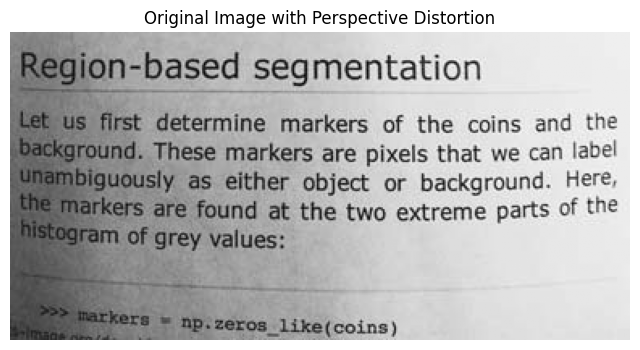

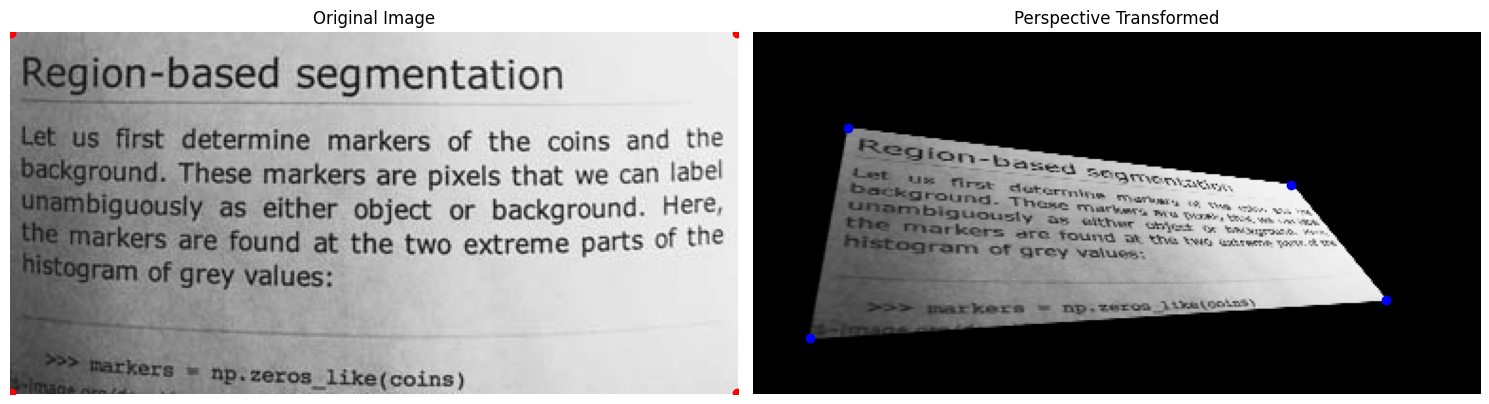

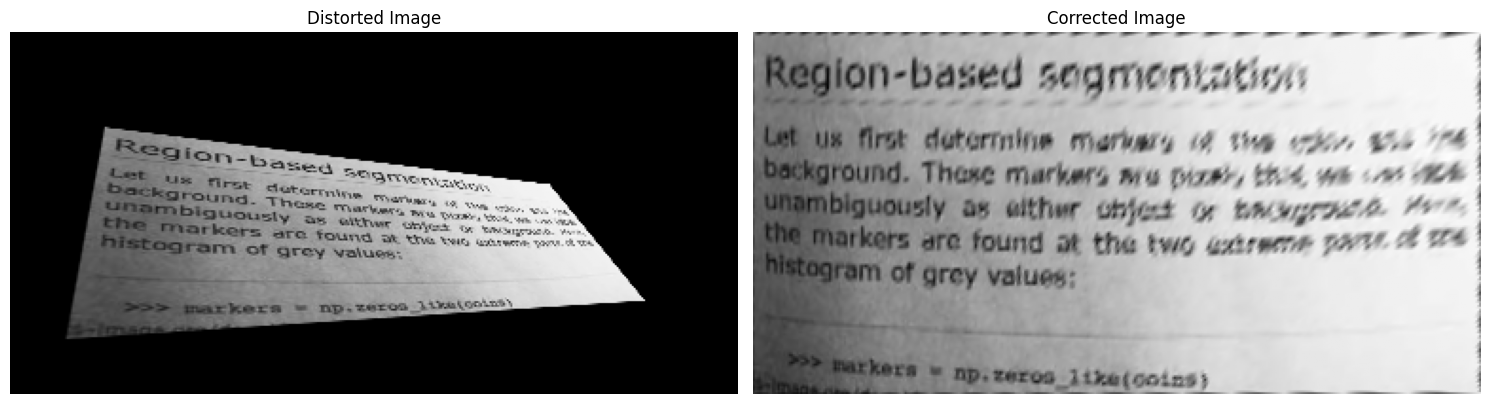

In [44]:
# Load an image with perspective distortion (or simulate one)
img = data.page()

# Display the original image
plt.figure(figsize=(8, 8))
plt.imshow(img, cmap='gray')
plt.title("Original Image with Perspective Distortion")
plt.axis('off')
plt.show()

# Define source points (corners of the distorted document)
src = np.array([
    [0, 0],  # Top-left
    [img.shape[1] - 1, 0],  # Top-right
    [img.shape[1] - 1, img.shape[0] - 1],  # Bottom-right
    [0, img.shape[0] - 1]  # Bottom-left
])

# Define destination points (where corners should be in the result)
# Simulate a perspective distortion
dst = np.array([
    [50, 50],  # Top-left
    [img.shape[1] - 100, 80],  # Top-right
    [img.shape[1] - 50, img.shape[0] - 50],  # Bottom-right
    [30, img.shape[0] - 30]  # Bottom-left
])

# Estimate the perspective transform matrix
tform = transform.ProjectiveTransform()
tform.estimate(src, dst)

# Warp the image according to the transform
warped = transform.warp(img, tform.inverse)

# Display the original and warped images
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Image')
axes[0].plot(src[:, 0], src[:, 1], 'ro')  # Show source points
axes[0].axis('off')

axes[1].imshow(warped, cmap='gray')
axes[1].set_title('Perspective Transformed')
axes[1].plot(dst[:, 0], dst[:, 1], 'bo')  # Show destination points
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Demonstrate perspective correction: Warp the distorted image back
tform_inv = transform.ProjectiveTransform()
tform_inv.estimate(dst, src)  # Note: src and dst are swapped
corrected = transform.warp(warped, tform_inv.inverse)

# Display the distorted and corrected images
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].imshow(warped, cmap='gray')
axes[0].set_title('Distorted Image')
axes[0].axis('off')

axes[1].imshow(corrected, cmap='gray')
axes[1].set_title('Corrected Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

Pasamos al Problema2 para mejorar la visualizacion y interaccion con dichas imagenes

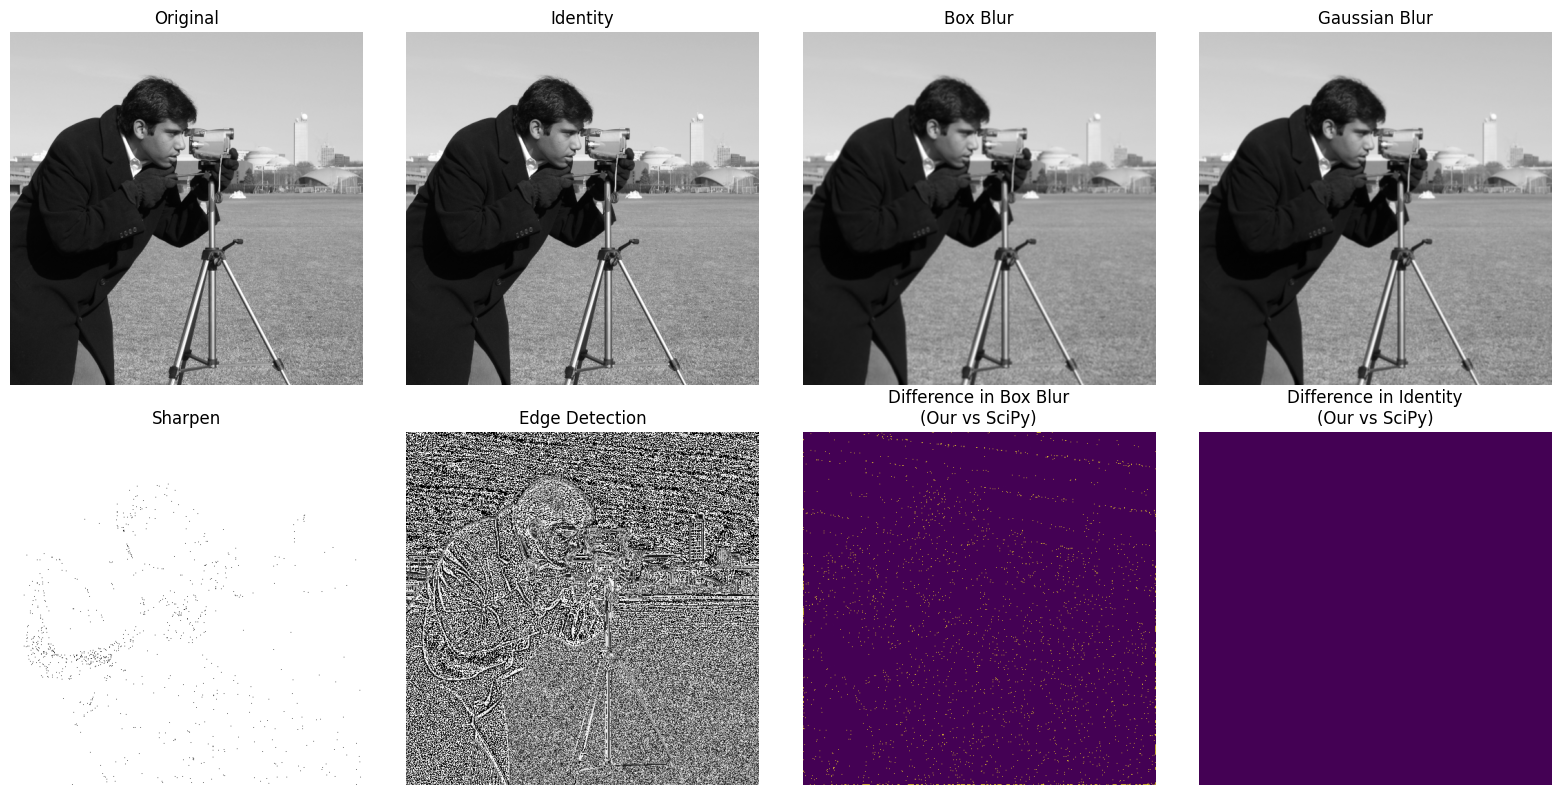

In [49]:
from scipy import ndimage

# Implement a simple convolution function to understand the process
def my_convolve2d(image, kernel):
    # Get kernel dimensions
    k_height, k_width = kernel.shape

    # Calculate padding
    pad_h = k_height // 2
    pad_w = k_width // 2

    # Pad the image
    padded_img = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='reflect')

    # Create output image
    output = np.zeros_like(image)

    # Perform convolution
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # Extract region of interest
            roi = padded_img[i:i+k_height, j:j+k_width]
            # Apply kernel and sum
            output[i, j] = np.sum(roi * kernel)

    return output

# Load a grayscale image
img = data.camera()

# Define some common kernels
identity = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
])

box_blur = np.ones((3, 3)) / 9

gaussian_blur = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
]) / 16

sharpen = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

edge_detect = np.array([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]
])

# Apply kernels using our function (for small kernels only) and scipy for comparison
identity_my = my_convolve2d(img, identity)
box_blur_my = my_convolve2d(img, box_blur)

# Use scipy for all kernels (more efficient)
identity_scipy = ndimage.convolve(img, identity)
box_blur_scipy = ndimage.convolve(img, box_blur)
gaussian_blur_scipy = ndimage.convolve(img, gaussian_blur)
sharpen_scipy = np.clip(ndimage.convolve(img, sharpen), 0, 1)
edge_detect_scipy = ndimage.convolve(img, edge_detect)

# Display results
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

axes[0, 0].imshow(img, cmap='gray')
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

axes[0, 1].imshow(identity_scipy, cmap='gray')
axes[0, 1].set_title('Identity')
axes[0, 1].axis('off')

axes[0, 2].imshow(box_blur_scipy, cmap='gray')
axes[0, 2].set_title('Box Blur')
axes[0, 2].axis('off')

axes[0, 3].imshow(gaussian_blur_scipy, cmap='gray')
axes[0, 3].set_title('Gaussian Blur')
axes[0, 3].axis('off')

axes[1, 0].imshow(sharpen_scipy, cmap='gray')
axes[1, 0].set_title('Sharpen')
axes[1, 0].axis('off')

axes[1, 1].imshow(edge_detect_scipy, cmap='gray')
axes[1, 1].set_title('Edge Detection')
axes[1, 1].axis('off')

# Show comparison between our implementation and scipy
axes[1, 2].imshow(np.abs(box_blur_my - box_blur_scipy), cmap='viridis')
axes[1, 2].set_title('Difference in Box Blur\n(Our vs SciPy)')
axes[1, 2].axis('off')

axes[1, 3].imshow(np.abs(identity_my - identity_scipy), cmap='viridis')
axes[1, 3].set_title('Difference in Identity\n(Our vs SciPy)')
axes[1, 3].axis('off')

plt.tight_layout()
plt.show()